# Práctica 2: PCA

**Román Alberto Vélez Jiménez**

CU: 165462

Fecha: 27 Oct 23

**Problema**: de la base de datos [red wine](!https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009/) de kaggle, se hará un análisis PCA. El objetivo es poder observar si es posible reducir la dimensionalidad de los datos y poder clasificarlos en base a la calidad del vino.

In [13]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')
# ignore numpy warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# pandas format only 4 decimal places
pd.options.display.float_format = '{:,.4f}'.format

# Red Wine Quality

## Los Datos

Se observan 12 columnas y 1599 filas, donde la columna de calidad es la variable objetivo. Ninguna variable contiene vacíos. Las variables son las siguientes:
- fixed acidity: acidez fija
- volatile acidity: acidez volátil
- citric acid: ácido cítrico
- residual sugar: azúcar residual
- chlorides: cloruros
- free sulfur dioxide: dióxido de azufre libre
- total sulfur dioxide: dióxido de azufre total
- density: densidad
- pH: pH
- sulphates: sulfatos
- alcohol: alcohol
- quality: calidad (puntuación entre 3 y 8)

In [2]:
# read data from numpy
red_wine = pd.read_csv("data/winequality-red.csv")

Un ejemplo de las primeras 5 observaciones se puede ver en la siguiente tabla

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fixed acidity</th>
      <th>volatile acidity</th>
      <th>citric acid</th>
      <th>residual sugar</th>
      <th>chlorides</th>
      <th>free sulfur dioxide</th>
      <th>total sulfur dioxide</th>
      <th>density</th>
      <th>pH</th>
      <th>sulphates</th>
      <th>alcohol</th>
      <th>quality</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>7.4</td>
      <td>0.70</td>
      <td>0.00</td>
      <td>1.9</td>
      <td>0.076</td>
      <td>11.0</td>
      <td>34.0</td>
      <td>0.9978</td>
      <td>3.51</td>
      <td>0.56</td>
      <td>9.4</td>
      <td>5</td>
    </tr>
    <tr>
      <th>1</th>
      <td>7.8</td>
      <td>0.88</td>
      <td>0.00</td>
      <td>2.6</td>
      <td>0.098</td>
      <td>25.0</td>
      <td>67.0</td>
      <td>0.9968</td>
      <td>3.20</td>
      <td>0.68</td>
      <td>9.8</td>
      <td>5</td>
    </tr>
    <tr>
      <th>2</th>
      <td>7.8</td>
      <td>0.76</td>
      <td>0.04</td>
      <td>2.3</td>
      <td>0.092</td>
      <td>15.0</td>
      <td>54.0</td>
      <td>0.9970</td>
      <td>3.26</td>
      <td>0.65</td>
      <td>9.8</td>
      <td>5</td>
    </tr>
    <tr>
      <th>3</th>
      <td>11.2</td>
      <td>0.28</td>
      <td>0.56</td>
      <td>1.9</td>
      <td>0.075</td>
      <td>17.0</td>
      <td>60.0</td>
      <td>0.9980</td>
      <td>3.16</td>
      <td>0.58</td>
      <td>9.8</td>
      <td>6</td>
    </tr>
    <tr>
      <th>4</th>
      <td>7.4</td>
      <td>0.70</td>
      <td>0.00</td>
      <td>1.9</td>
      <td>0.076</td>
      <td>11.0</td>
      <td>34.0</td>
      <td>0.9978</td>
      <td>3.51</td>
      <td>0.56</td>
      <td>9.4</td>
      <td>5</td>
    </tr>
  </tbody>
</table>

In [3]:
# drop 'quality'
quality_by_wine = red_wine['quality'].copy()
quality_by_wine = 'quality_' + quality_by_wine.astype(str)
red_wine = red_wine.drop('quality', axis='columns')

## Preparando los Datos

Para hacer el análisis PCA, primero se estandarizó la data para que tenga media 0 y desviación estándar 1. Esto se hace para que las variables tengan el mismo peso en el análisis. Obtenemos la matriz de covarianza usando el sesgo de Besel: $$\frac{1}{n-1}(X - \mu)^T(X - \mu).$$

In [4]:
# get numpy array
X = red_wine.copy().to_numpy()

In [5]:
# scale array
Xstand = X - np.mean(X, axis=0)
Xstand = np.divide(Xstand, np.std(Xstand, ddof=1, axis=0))

In [ ]:
# variance-covariance matrix
m_size = Xstand.shape[0]
S = (1 / (m_size - 1)) * (Xstand.T @ Xstand)

### Mapa de Calor

Para entender las relaciones entre variables, se muestra en la figura de abajo la matriz de varianzas y covarianzas. Se observa una fuerte correlación entre `free sulfure dioxide` y `total sulfure dioxide`, por lo que es muy probable que están correlacionadas, por lo que seguramente una componente principal tendrá muy poca varianza explciada gracias a la colinealidad de estas dos variables. De igual forma vemos la fuerte relación entre `volatile acidity` y `citric acid`.

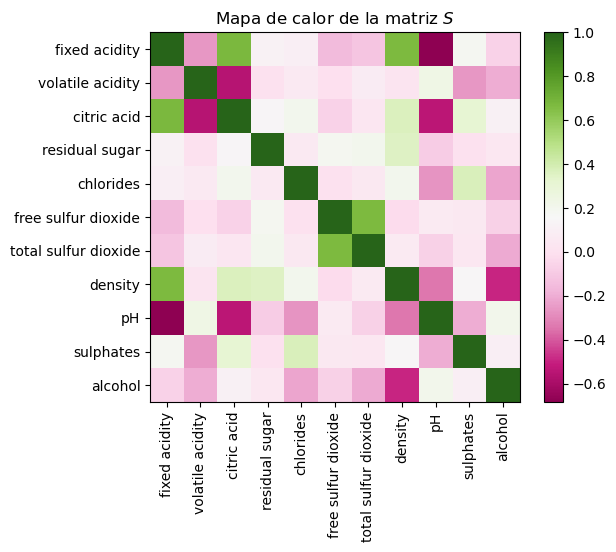

In [7]:
# create a heatmap
plt.imshow(S, cmap='PiYG', interpolation='nearest')
plt.colorbar()
# add ticks
plt.xticks(range(len(red_wine.columns)), red_wine.columns, rotation=90)
plt.yticks(range(len(red_wine.columns)), red_wine.columns, rotation=0)
# add title
plt.title("Mapa de calor de la matriz $S$")
# Display the plot or save it to a file
plt.show()

# PCA

## Cálculo de los valores y vectores propios

Pimero se hizo el cálculo de eigenvectores a partir de la matriz de varianzas y covarianzas $S$. Se obtuvieron 12 eigenvectores y eigenvalores. Observamos que la varianza explicada para las variables 1 y 2 es moderadamente buena, pues con solo dos variables se logra explicar casi el 50% de la varianza de 12 variables. Por lo que podemos decir que estas variables son las que más explican la varianza de los datos. De todos modos, observamos como se ve con 3 componentes, las cuales ya explican el 60% de la varianza total. Esto se puede observar en la figura de abajo.

In [8]:
# get eigenvectors
eigvalues, eigvectors = np.linalg.eig(S)

In [9]:
# proyect data
Xstand_proy = Xstand @ eigvectors

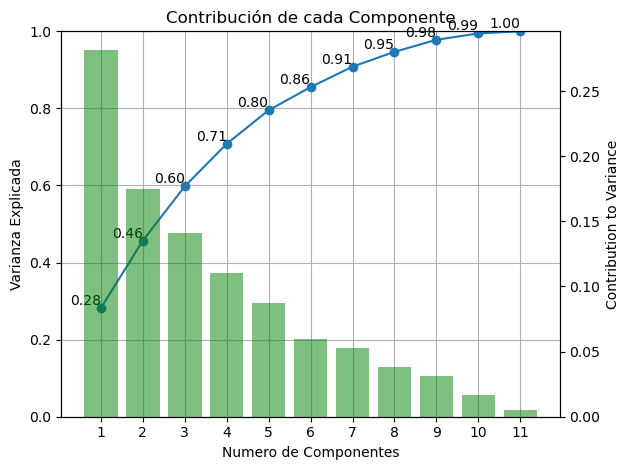

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming eigvalues is a numpy array containing the eigenvalues
# Sort the eigenvalues in descending order
eigvalues.sort()
eigvalues = eigvalues[::-1]

# Calculate the cumulative explained variance
cumulative_variance = eigvalues.cumsum() / eigvalues.sum()

# Create a figure and axis for the cumulative variance explained graph
fig, ax = plt.subplots()

# Plot the cumulative explained variance
ax.plot(np.arange(1, eigvalues.size + 1), cumulative_variance, '-o')

# Set better formatting for the tick labels
ax.set_xticks(np.arange(1, eigvalues.size + 1))
ax.set_xticklabels(np.arange(1, eigvalues.size + 1))
ax.set_xlabel("Numero de Componentes")
ax.set_ylabel("Varianza Explicada")
ax.grid(True)

# Annotate data points with y-values
for i, var in enumerate(cumulative_variance):
    ax.text(i + 1, var, f'{var:.2f}', ha='right', va='bottom')

# set limits
ax.set_ylim(0, 1)

# Create a bar chart for individual contributions
individual_contributions = eigvalues / eigvalues.sum()
x = np.arange(1, eigvalues.size + 1)
ax2 = ax.twinx()  # Create a secondary y-axis
ax2.bar(x, individual_contributions, align='center', alpha=0.5, color='g', label='Contribución Individual')
ax2.set_ylabel("Contribution to Variance")

# Show the plot
plt.title("Contribución de cada Componente")
plt.tight_layout()
plt.show()

## Contribución de las Variables

La primera componente podría explicar el tradeoff entre acidez y alcanilidad, mientras que la segunda componente podría explicar el tradeoff entre alcohol y carbonatado. En la tabla de acontinuación se puede observar la contribución de cada variable a cada componente. 

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>PC1</th>
      <th>PC2</th>
      <th>PC3</th>
      <th>PC4</th>
      <th>PC5</th>
      <th>PC6</th>
      <th>PC7</th>
      <th>PC8</th>
      <th>PC9</th>
      <th>PC10</th>
      <th>PC11</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>fixed acidity</th>
      <td>0.4893</td>
      <td>-0.1105</td>
      <td>-0.1233</td>
      <td>-0.2296</td>
      <td>-0.0826</td>
      <td>-0.6397</td>
      <td>-0.2495</td>
      <td>0.1940</td>
      <td>-0.1776</td>
      <td>-0.3502</td>
      <td>0.1015</td>
    </tr>
    <tr>
      <th>volatile acidity</th>
      <td>-0.2386</td>
      <td>0.2749</td>
      <td>-0.4500</td>
      <td>0.0790</td>
      <td>0.2187</td>
      <td>-0.0024</td>
      <td>0.3659</td>
      <td>-0.1291</td>
      <td>-0.0788</td>
      <td>-0.5337</td>
      <td>0.4114</td>
    </tr>
    <tr>
      <th>citric acid</th>
      <td>0.4636</td>
      <td>-0.1518</td>
      <td>0.2382</td>
      <td>-0.0794</td>
      <td>-0.0586</td>
      <td>0.0709</td>
      <td>0.6217</td>
      <td>-0.3814</td>
      <td>-0.3775</td>
      <td>0.1055</td>
      <td>0.0696</td>
    </tr>
    <tr>
      <th>residual sugar</th>
      <td>0.1461</td>
      <td>0.2721</td>
      <td>0.1013</td>
      <td>-0.3728</td>
      <td>0.7321</td>
      <td>-0.1840</td>
      <td>0.0929</td>
      <td>0.0075</td>
      <td>0.2998</td>
      <td>0.2907</td>
      <td>0.0492</td>
    </tr>
    <tr>
      <th>chlorides</th>
      <td>0.2122</td>
      <td>0.1481</td>
      <td>-0.0926</td>
      <td>0.6662</td>
      <td>0.2465</td>
      <td>-0.0531</td>
      <td>-0.2177</td>
      <td>0.1113</td>
      <td>-0.3570</td>
      <td>0.3704</td>
      <td>0.3043</td>
    </tr>
    <tr>
      <th>free sulfur dioxide</th>
      <td>-0.0362</td>
      <td>0.5136</td>
      <td>0.4288</td>
      <td>-0.0435</td>
      <td>-0.1592</td>
      <td>0.0514</td>
      <td>0.2485</td>
      <td>0.6354</td>
      <td>-0.2048</td>
      <td>-0.1166</td>
      <td>-0.0140</td>
    </tr>
    <tr>
      <th>total sulfur dioxide</th>
      <td>0.0236</td>
      <td>0.5695</td>
      <td>0.3224</td>
      <td>-0.0346</td>
      <td>-0.2225</td>
      <td>-0.0687</td>
      <td>-0.3708</td>
      <td>-0.5921</td>
      <td>0.0190</td>
      <td>-0.0937</td>
      <td>0.1363</td>
    </tr>
    <tr>
      <th>density</th>
      <td>0.3954</td>
      <td>0.2336</td>
      <td>-0.3389</td>
      <td>-0.1745</td>
      <td>0.1571</td>
      <td>0.5673</td>
      <td>-0.2400</td>
      <td>0.0207</td>
      <td>-0.2392</td>
      <td>-0.1705</td>
      <td>-0.3912</td>
    </tr>
    <tr>
      <th>pH</th>
      <td>-0.4385</td>
      <td>0.0067</td>
      <td>0.0577</td>
      <td>-0.0038</td>
      <td>0.2675</td>
      <td>-0.3407</td>
      <td>-0.0110</td>
      <td>-0.1677</td>
      <td>-0.5614</td>
      <td>-0.0251</td>
      <td>-0.5221</td>
    </tr>
    <tr>
      <th>sulphates</th>
      <td>0.2429</td>
      <td>-0.0376</td>
      <td>0.2798</td>
      <td>0.5509</td>
      <td>0.2260</td>
      <td>-0.0696</td>
      <td>0.1123</td>
      <td>-0.0584</td>
      <td>0.3746</td>
      <td>-0.4475</td>
      <td>-0.3813</td>
    </tr>
    <tr>
      <th>alcohol</th>
      <td>-0.1132</td>
      <td>-0.3862</td>
      <td>0.4717</td>
      <td>-0.1222</td>
      <td>0.3507</td>
      <td>0.3145</td>
      <td>-0.3030</td>
      <td>0.0376</td>
      <td>-0.2176</td>
      <td>-0.3277</td>
      <td>0.3616</td>
    </tr>
  </tbody>
</table>

In [11]:
# look eigenvectors
df_eig = pd.DataFrame(
    eigvectors,
    columns=['PC' + str(i+1) for i in range(eigvalues.size)],
    index=red_wine.columns
)

Vemos que en la primera componente, la `fixed acidity` es la variable que más aporta información. Por otro lado, la que más aporta en la segunda componente es `total sulfur dioxide`. Esto nos indica que estas dos variables son las que más variación aportan al modelo.

Pareciera, por la matriz de varianzas y covarianzas $S$, que la variable `fixed acidity` es la que tiene mayor correlación con las demás variables, por lo que es la que más contribuye a la varianza de los datos. 

## Valores Proyectados

Al graficar las primeras 2 componentes principales, se puede observar que las componentes principales no son capaces de separar del todo las clases de vino por calidad. Si bien se ve un poco de orden creciente de arriba hacia abajo, la separación no es evidente. Esto se puede observar en la última figura.

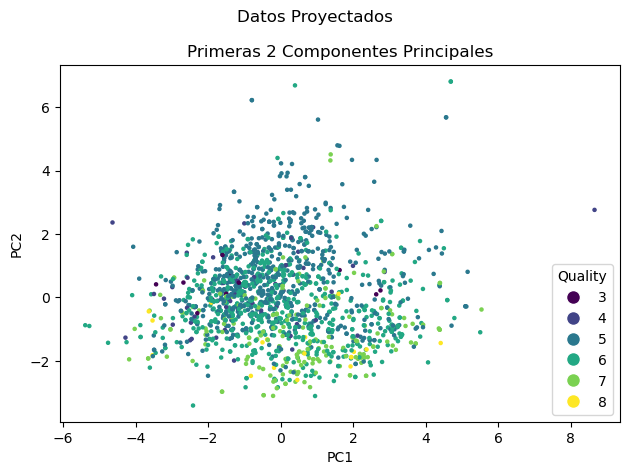

In [12]:
df = pd.DataFrame(Xstand_proy[:, :3], columns=["PC1", "PC2", "PC3"])
df["quality"] = pd.Categorical(quality_by_wine, categories=quality_by_wine.sort_values().unique(), ordered=True)

# Scatter plot of the first two vectors
scatter = plt.scatter(df['PC1'], df['PC2'], c=df['quality'].cat.codes, cmap='viridis', s=5)

# Add labels
plt.xlabel('PC1')
plt.ylabel('PC2')

# Create a legend
quality_values = df['quality'].sort_values().cat.codes.unique()
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(quality_values[i])),
                              markersize=10, label=quality_values[i]+3) for i in range(len(quality_values))]
plt.legend(handles=legend_elements, title='Quality')

# Show the plot
plt.suptitle("Datos Proyectados")
plt.title("Primeras 2 Componentes Principales")
plt.tight_layout()
plt.show()

# Referencias

- [Analisis Numerico, Erick Palacios, 2022](!https://itam-ds.github.io/analisis-numerico-computo-cientifico/README.html)